# Ball And Stick2

In [1]:
from neuron import h, gui
from neuron.units import ms, mV
h.load_file('stdrun.hoc')
pass

In [2]:
class Cell:
    def __init__(self, gid, x, y, z, theta):
        self._gid = gid
        self._setup_morphology()
        self.all = self.soma.wholetree()
        self._setup_biophysics()
        self.x = self.y = self.z = 0              
        h.define_shape()
        self._rotate_z(theta)                       
        self._set_position(x, y, z)                
        
    def __repr__(self):
        return '{}[{}]'.format(self.name, self._gid)
    
    def _set_position(self, x, y, z):
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(i,
                               x - self.x + sec.x3d(i),
                               y - self.y + sec.y3d(i),
                               z - self.z + sec.z3d(i),
                              sec.diam3d(i))
        self.x, self.y, self.z = x, y, z
    def _rotate_z(self, theta):
        for sec in self.all:
            for i in range(sec.n3d()):
                x = sec.x3d(i)
                y = sec.y3d(i)
                c = h.cos(theta)
                s = h.sin(theta)
                xprime = x * c - y * s
                yprime = x * s + y * c
                sec.pt3dchange(i, xprime, yprime, sec.z3d(i), sec.diam3d(i))
                """
                sec.pt3dchange(i, xprime, yprime, sec.z3d(i), sec.diam3d(i))의 역할:
                (x, y, z, theta)의 position을 가지고 있던 공간상의 cell i에 대하여
                position을 (xprime, yprime, sec.z3d(i), sec.diam3d(i))로 modify.
                """
"""
Generic Cell class 선언부
Cell(a, b, c, d, e)를 accept할 경우 a번째 cell을 (b, c, d)의 공간 좌표 상에 놓은 다음
z축을 기준으로 e radian만큼 회전시킨다.
"""
pass

In [3]:
class BallAndStick(Cell):
    name = 'BallAndStick'
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1
    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        self.soma.insert('hh')                                          
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003    # Leak conductance in S/cm2
            seg.hh.el = -54.3     # Reversal potential in mV
        # Insert passive current in the dendrite
        self.dend.insert('pas')                 
        for seg in self.dend:
            seg.pas.g = 0.001  # Passive conductance in S/cm2
            seg.pas.e = -65    # Leak reversal potential mV
"""
Ball And Stick1에서 다루었던 신경 세포 class.
이 때, __init__과 __repr__ method, self.all을 제거되었다는 차이점이 있다.
Soma와 Dendrite를 함께 고려하기 위함이다.
"""
pass

In [4]:
def create_n_BallAndStick(n, r):
    cells = []
    for i in range(n):
        theta = i * 2 * h.PI / n
        cells.append(BallAndStick(i, h.cos(theta) * r, h.sin(theta) * r, 0, theta))
    return cells
    """
    2pi를 n으로 나누어 각 부분에 n개만큼 입력한 cell을 배치하고
    이 cell들을 cells list로 묶어 한꺼번에 return.
    """

"""
n개의 cell을 원형으로 배치하는 function.
r은 배치할 원의 반경의 micron 단위이다.
"""
pass

In [5]:
my_cells = create_n_BallAndStick(7, 50)
ps=h.PlotShape(True)
ps.show(0)
"""
my_cells를 7개의 세포를 z=0인 평면에 균등하게 배치 후 GUI로 표현.
"""
pass

In [6]:
print(my_cells)

[BallAndStick[0], BallAndStick[1], BallAndStick[2], BallAndStick[3], BallAndStick[4], BallAndStick[5], BallAndStick[6]]


In [7]:
"""
NetStim

하나의 세포에 CurrentClamp를 통해 자극을 준 #1과 달리,
가상 시냅스를 할당해서 synaptic event를 통해 세포를 구동할 것.

Object간의 Event-based communication은 NetCons라는 network connecton object를 통해 발생한다.
각 NetCon은 source와 traget을 가지고, 이 중 source는 spike의 역치를 찾는 역할을 한다.
spike가 detect되면, NetCon은 target에 message를 보낸다.

NetStim은 NetCon의 source를 자극하기 위한 spike generator이다.
"""
stim = h.NetStim()
syn_ = h.ExpSyn(my_cells[0].dend(0.5))
"""
새로운 Stimulator의 선언.
첫 cell의 Dendrite의 중심의 synapse에 attach.
ExpSyn은 AMPA synapse와 비슷한 행동을 보이는 synapse를 선언함.
"""

stim.number = 1
stim.start = 9
ncstim = h.NetCon(stim, syn_)  #h.NetCon(stim, syn_) : stim type의 stimulation을 syn_ synapse에 netcon 형태로 주입.
ncstim.delay = 1*ms
ncstim.weight[0] = 0.04  #Vector형태의 NetCon weight.

syn_.tau = 2*ms  #synapse syn_의 시간상수 tau를 결정.
print('Reversal potential = {} mV'.format(syn_.e))

Reversal potential = 0.0 mV


In [8]:
recording_cell = my_cells[0]
soma_v = h.Vector().record(recording_cell.soma(0.5)._ref_v)
dend_v = h.Vector().record(recording_cell.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)
%matplotlib inline
import matplotlib.pyplot as plt

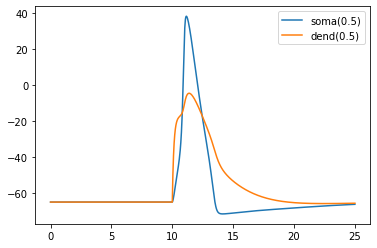

In [9]:
h.finitialize(-65*mV)
h.continuerun(25*ms)
plt.plot(t, soma_v, label='soma(0.5)')
plt.plot(t, dend_v, label='dend(0.5)')
plt.legend()
plt.show()

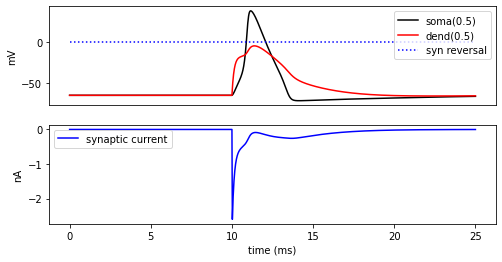

In [10]:
syn_i = h.Vector().record(syn_._ref_i)  #Synaptic current를 record하는 vector.

h.finitialize(-65 * mV)
h.continuerun(25 * ms)

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(2, 1, 1)  #(8,4)의 figure를 2분할, 1분할하여 그 중 첫 번째를 ax1으로 define
soma_plot = ax1.plot(t, soma_v, color='black', label='soma(0.5)')
dend_plot = ax1.plot(t, dend_v, color='red', label='dend(0.5)')
rev_plot = ax1.plot([t[0], t[-1]], [syn_.e, syn_.e], label='syn reversal', color='blue', linestyle=':')
# (t[0], syn_.e)와 (t[-1], syn_.e)를 잇는 선분을 파란 점선으로 표현.
ax1.legend()
ax1.set_ylabel('mV')
ax1.set_xticks([])

ax2 = fig.add_subplot(2, 1, 2)  #같은 방식으로 2번째를 ax2로 define.
syn_plot = ax2.plot(t, syn_i, color='blue', label='synaptic current')
ax2.legend()
ax2.set_ylabel(h.units('ExpSyn.i'))
ax2.set_xlabel('time (ms)')
plt.show()

In [11]:
"""
Connecting the Cells

n번째 cell에서 n+1번째 cell의 middle of dendrite에 synapse를 통해 자극을 전달을 목적.
이 때, soma에서 action potential이 일어나면, spike가 axon을 따라 전파되어 잠깐의 delay 후 target cell의 dendrite에 synaptic event를 유도한다.
따라서, spike detector를 pre cell의 soma에 설치하여야 한다.
"""
syns = []
netcons = []
for source, target in zip(my_cells, my_cells[1:] + [my_cells[0]]):
# zip은 각 cell을 다음 cell과 쌍으로 구성되고, 여기에 마지막 cell과 첫 cell의 pair가 추가됨.
    syn = h.ExpSyn(target.dend(0.5))
    nc = h.NetCon(source.soma(0.5)._ref_v, syn, sec=source.soma)
    nc.weight[0] = 0.05
    nc.delay = 5
    netcons.append(nc)
    syns.append(syn)

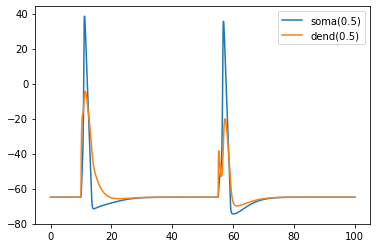

In [12]:
h.finitialize(-65*mV)
h.continuerun(100*ms)
plt.plot(t, soma_v, label='soma(0.5)')
plt.plot(t, dend_v, label='dend(0.5)')
plt.legend()
plt.show()
"""
my_cells[0]의 단일 cell을 plot해 보면, 두 번 이상의 spike가 발생함을 확인할 수 있다.
이는 spike가 network를 통해 전송되고 있음을 시사한다.
"""
pass

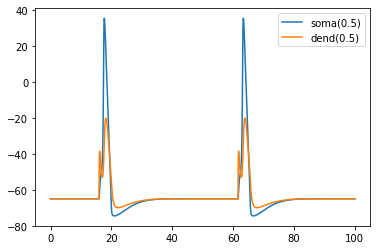

In [13]:
"""
As an Exercise : how about my_cells[1]?
"""
recording_cell1 = my_cells[1]
soma_v1 = h.Vector().record(recording_cell1.soma(0.5)._ref_v)
dend_v1 = h.Vector().record(recording_cell1.dend(0.5)._ref_v)

h.finitialize(-65*mV)
h.continuerun(100*ms)
plt.plot(t, soma_v1, label='soma(0.5)')
plt.plot(t, dend_v1, label='dend(0.5)')
plt.legend()
plt.show()
"""
recording_cell1이라는 새로운 변수를 my_cells[1]으로 잡고 
해당 cell에 대한 soma와 dend vector들을 각각 soma_v1, dend_v1으로 추출.

plot결과, my_cells[0]으로부터 EPSP를 받아 action potential이 형성되었고, my_cells[0]과 비교하여 다소 delayed 되어있음을 확인할 수 있다.
또한, NetCon을 통해 탈분극된 my_cells[0]의 dendrite spike와 달리 첫 spike부터 dendrite potential이 크게 꺾임을 확인할 수 있다.
"""
pass

cell 0: [10.925000000099914, 56.60000000010431]
cell 1: [17.450000000099543, 63.12500000010579]
cell 2: [23.975000000099172, 69.65000000010727]
cell 3: [30.5000000000988, 76.17500000010875]
cell 4: [37.02500000009986, 82.70000000011024]
cell 5: [43.55000000010134, 89.22500000011172]
cell 6: [50.075000000102825, 95.7500000001132]


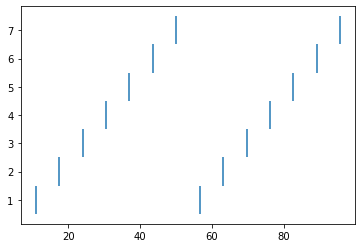

In [14]:
spike_times = [h.Vector() for nc in netcons]
for nc, spike_times_vec in zip(netcons, spike_times):
    nc.record(spike_times_vec)
"""
NetCon.record를 이용하여 Vector object에 spike를 record할 수 있다.
"""
h.finitialize(-65 * mV)
h.continuerun(100 * ms)
for i, spike_times_vec in enumerate(spike_times):
    print('cell {}: {}'.format(i, list(spike_times_vec)))

import matplotlib.pyplot as plt
plt.figure()

for i, spike_times_vec in enumerate(spike_times):
    plt.vlines(spike_times_vec, i + 0.5, i + 1.5)
plt.show()

In [15]:
h.topology()


|-|       BallAndStick[0].soma(0-1)
   `|       BallAndStick[0].dend(0-1)
|-|       BallAndStick[1].soma(0-1)
   `|       BallAndStick[1].dend(0-1)
|-|       BallAndStick[2].soma(0-1)
   `|       BallAndStick[2].dend(0-1)
|-|       BallAndStick[3].soma(0-1)
   `|       BallAndStick[3].dend(0-1)
|-|       BallAndStick[4].soma(0-1)
   `|       BallAndStick[4].dend(0-1)
|-|       BallAndStick[5].soma(0-1)
   `|       BallAndStick[5].dend(0-1)
|-|       BallAndStick[6].soma(0-1)
   `|       BallAndStick[6].dend(0-1)



1.0